Total combinations: 1191
{'batch_size': 160, 'dropout': np.float64(0.021737361675638306), 'hidden_layer_dim': 104, 'learning_rate': np.float64(0.0011806951950673143)}
{'batch_size': 135, 'dropout': np.float64(0.004853073707679928), 'hidden_layer_dim': 273, 'learning_rate': np.float64(0.000126472899785809)}
{'batch_size': 190, 'dropout': np.float64(0.14576717561333025), 'hidden_layer_dim': 66, 'learning_rate': np.float64(0.00010279338292214311)}
{'batch_size': 161, 'dropout': np.float64(0.11898435854305778), 'hidden_layer_dim': 42, 'learning_rate': np.float64(0.0014719130011447052)}
{'batch_size': 163, 'dropout': np.float64(0.12393362309421482), 'hidden_layer_dim': 138, 'learning_rate': np.float64(0.00026024204439267047)}
{'batch_size': 135, 'dropout': np.float64(0.09715080602394235), 'hidden_layer_dim': 114, 'learning_rate': np.float64(0.0016293616626152333)}
{'batch_size': 106, 'dropout': np.float64(0.07036798895366989), 'hidden_layer_dim': 90, 'learning_rate': np.float64(0.0029984812

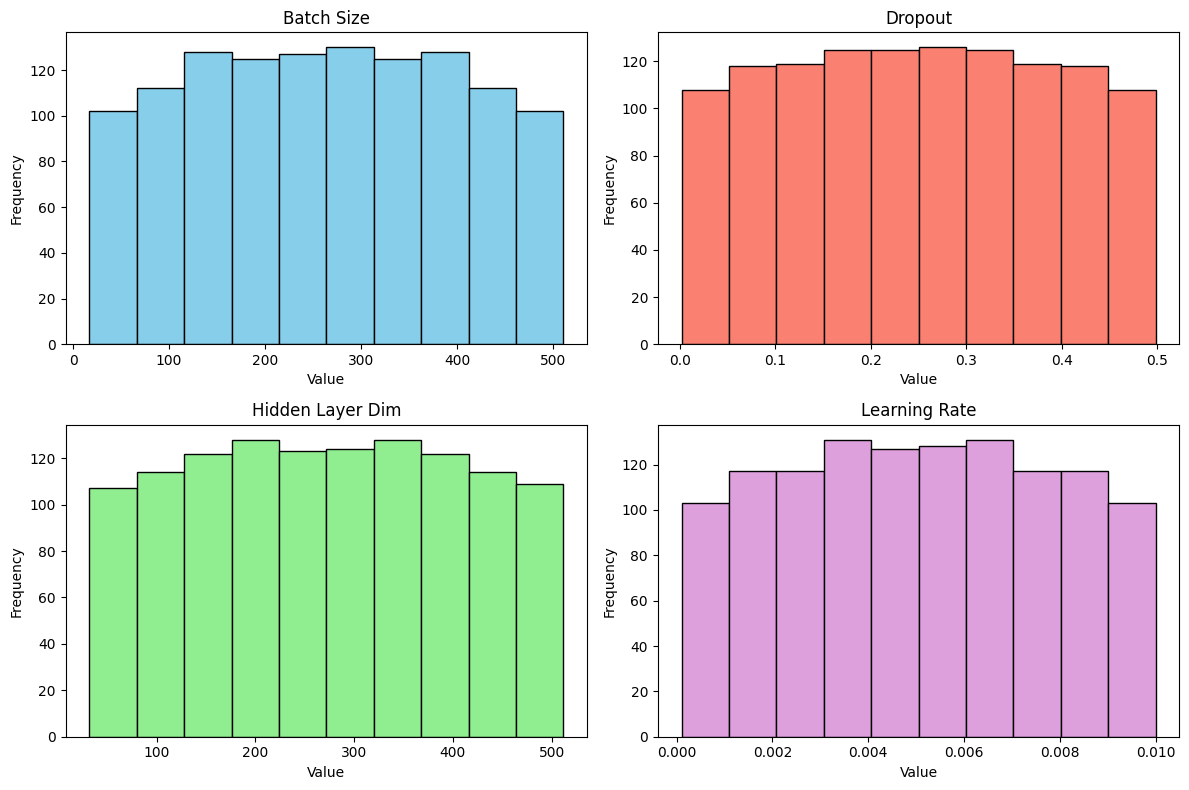

In [1]:
import numpy as np
import itertools
import math

def rotated_grid_centered(ranges, m=4, theta_deg=20, integer_keys=None):
    """
    Rotated grid search with hypercube initially spanning [-0.5, 1.5] (center=1),
    rotated in n dimensions, then mapped back to hyperparameter ranges.

    ranges: dict {param_name: (low, high)}
    m: points per dimension
    theta_deg: rotation angle
    integer_keys: list of keys to round to integer
    """
    if integer_keys is None:
        integer_keys = []

    keys = list(ranges.keys())
    dims = len(keys)

    # 1. Create grid in [0, 1]
    axis_points = [np.linspace(0, 1, m) for _ in range(dims)]
    base_grid = np.array(list(itertools.product(*axis_points)))

    theta = math.radians(theta_deg)
    rotated_grid = []

    # 2. Rotate around center=1
    center = 0.5
    for p in base_grid:
        p_rot = p.copy()
        for i in range(dims):
            for j in range(i + 1, dims):
                x_shift = p_rot[i] - center
                y_shift = p_rot[j] - center
                x_rot = x_shift * np.cos(theta) - y_shift * np.sin(theta)
                y_rot = x_shift * np.sin(theta) + y_shift * np.cos(theta)
                p_rot[i] = x_rot + center
                p_rot[j] = y_rot + center
        rotated_grid.append(p_rot)

    rotated_grid = np.array(rotated_grid)

    # 3. Filter points: keep only points where all dimensions are in [0,1]
    rotated_grid = np.array([p for p in rotated_grid if np.all((p >= 0) & (p <= 1))])

    # 4. Map to actual hyperparameter ranges
    lo_vals = np.array([ranges[k][0] for k in keys])
    hi_vals = np.array([ranges[k][1] for k in keys])
    combos = []
    for p in rotated_grid:
        cfg = {}
        for idx, k in enumerate(keys):
            val = lo_vals[idx] + p[idx] * (hi_vals[idx] - lo_vals[idx])
            if k in integer_keys:
                val = int(round(val))
            cfg[k] = val
        combos.append(cfg)

    return combos


# ---------------------------
# Example usage
# ---------------------------
hyper_ranges = {
    'batch_size': (16, 512),
    'dropout': (0.0, 0.5),
    'hidden_layer_dim': (32, 512),
    'learning_rate': (0.0001, 0.01)
}

integer_keys = ['batch_size', 'hidden_layer_dim']

# Generate rotated grid
grid_combos = rotated_grid_centered(hyper_ranges, m=7, theta_deg=20, integer_keys=integer_keys)

print("Total combinations:", len(grid_combos))
for c in grid_combos:
    print(c)

import matplotlib.pyplot as plt

# Suppose grid_combos is your list of dictionaries
# Extract each hyperparameter
batch_sizes = [c['batch_size'] for c in grid_combos]
dropouts = [c['dropout'] for c in grid_combos]
hidden_dims = [c['hidden_layer_dim'] for c in grid_combos]
learning_rates = [c['learning_rate'] for c in grid_combos]

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].hist(batch_sizes, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_title('Batch Size')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(dropouts, bins=10, color='salmon', edgecolor='black')
axes[0,1].set_title('Dropout')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Frequency')

axes[1,0].hist(hidden_dims, bins=10, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Hidden Layer Dim')
axes[1,0].set_xlabel('Value')
axes[1,0].set_ylabel('Frequency')

axes[1,1].hist(learning_rates, bins=10, color='plum', edgecolor='black')
axes[1,1].set_title('Learning Rate')
axes[1,1].set_xlabel('Value')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
